**IMPORTING LIBRARIES**

In [68]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
import torchvision.datasets as datasets
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt

# Loading the datasets and One hot Function

In [69]:
# Set random seed for reproducibility
torch.manual_seed(42)

import torch.nn.functional as F

def one_hot(x):
    temp = torch.zeros(10)
    temp[x] = 1
    return temp

def transform(x):
    return np.asarray(x) / 255

train_dataset = datasets.MNIST(root='./data', train = True , download=True, target_transform = one_hot, transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.1307,), (0.3081,))]))
test_dataset = datasets.MNIST(root='./data', train = False ,download=True,target_transform = one_hot, transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

In [70]:
!nvidia-smi

Sat Sep 30 19:17:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    29W /  70W |    601MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Separating the train dataset into 50000 for training and 10000 for validation

In [71]:
num_validation_samples = 10000

train_dataset, validation_dataset = random_split(train_dataset, [len(train_dataset) - num_validation_samples, num_validation_samples])

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=100)
test_loader = DataLoader(test_dataset, batch_size=100)


# **Model:**

First we model the CNN according the instructions given in the question
Then we propagate it forward.

In [72]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 500)
        self.fc2 = nn.Linear(500, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.maxpool1(torch.relu(self.conv1(x)))
        x = self.maxpool2(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)

        return x

# Creating the model
model = CNNModel()

# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

We train the model on the dataset with 50000 datapoints and check the accuracy on the validation set and print the accuracy for each epoch. In this we take 5 epochs.

In [73]:
from torch.nn.functional import one_hot

train_loss_history = []
validation_loss_history = []
train_accuracy_history = []
validation_accuracy_history = []

# Train the model
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, one_hot_labels in train_loader:
        labels = torch.argmax(one_hot_labels, dim=1)  # Convert one-hot labels to integers
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_accuracy = 100 * correct_train / total_train
    train_loss_history.append(running_loss / len(train_loader))
    train_accuracy_history.append(train_accuracy)

    # Evaluate the model on the validation set
    model.eval()
    correct_val = 0
    total_val = 0
    running_val_loss = 0.0
    with torch.no_grad():
        for images, one_hot_labels in validation_loader:
            labels = torch.argmax(one_hot_labels, dim=1)  # Convert one-hot labels to integers
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    validation_accuracy = 100 * correct_val / total_val
    validation_loss_history.append(running_val_loss / len(validation_loader))
    validation_accuracy_history.append(validation_accuracy)
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}, Validation Accuracy: {validation_accuracy:.2f}%')


Epoch 1, Loss: 1.6215803849697112, Validation Accuracy: 88.27%
Epoch 2, Loss: 1.4958723096847535, Validation Accuracy: 97.62%
Epoch 3, Loss: 1.4784969153404235, Validation Accuracy: 98.48%
Epoch 4, Loss: 1.4755014548301697, Validation Accuracy: 98.57%
Epoch 5, Loss: 1.474306808948517, Validation Accuracy: 98.56%


We calculate the average prediction accuracy

In [74]:
avg = 0
for i in range(len(validation_accuracy_history)):
  avg += validation_accuracy_history[i]
avg = avg / len(validation_accuracy_history)

print("Average prediction accuracy =", avg)

Average prediction accuracy = 96.3


Plotting the training loss and validation loss against each epoch. Accuracies of training and validation are plotted too.


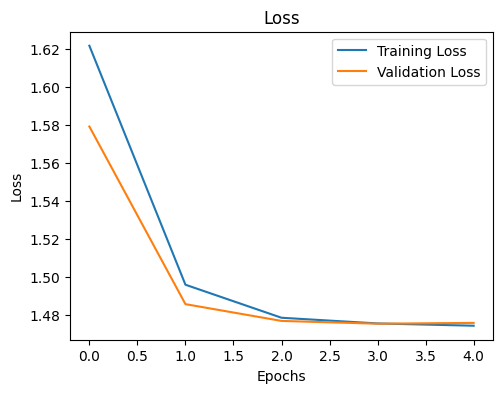

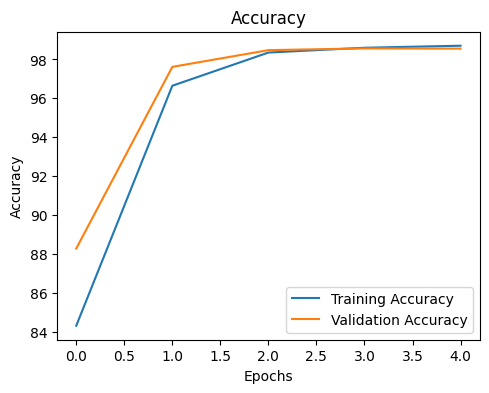

In [75]:
# Plot training and validation metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(validation_loss_history, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history, label='Training Accuracy')
plt.plot(validation_accuracy_history, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.show()

We perform testing on test data and print the accuracy.

In [76]:
# Test the model on the test set
model.eval()
correct_test = 0
total_test = 0
test_loss = 0.0
with torch.no_grad():
    for images, one_hot_labels in test_loader:
        labels = torch.argmax(one_hot_labels, dim=1)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
test_accuracy = 100 * correct_test / total_test
print(f'Test Accuracy: {test_accuracy:.2f}%')



Test Accuracy: 98.45%


Plotting randomly selected test images showing the true and predicted class labels.


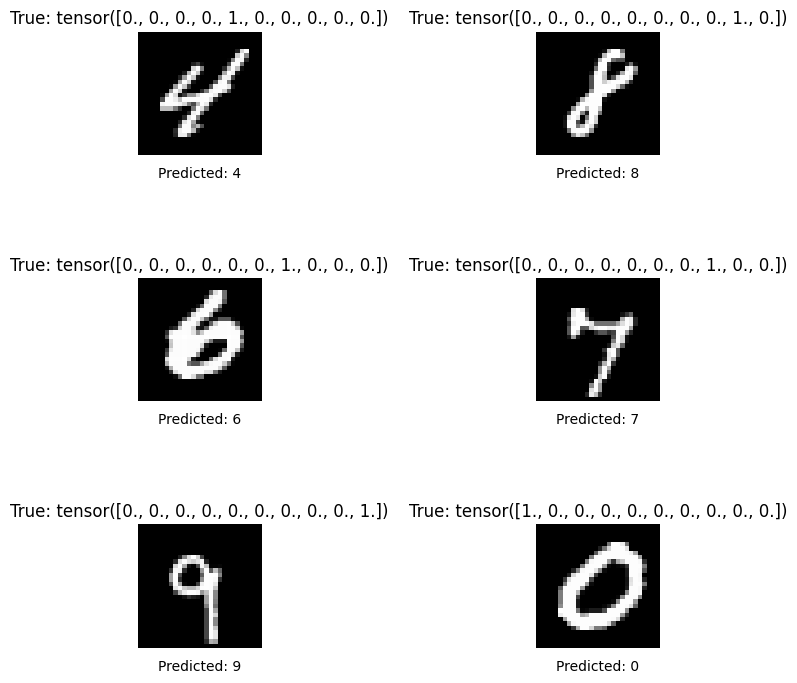

In [78]:
import torch

plt.figure(figsize=(8, 8))
num_rows = 3
num_cols = 2
random_indices = np.random.choice(len(test_dataset), size=num_rows * num_cols, replace=False)
for i, index in enumerate(random_indices):
    image, label = test_dataset[index]
    image = image.unsqueeze(0)  # Add batch dimension
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'True: {label}')
    plt.axis('off')
    with torch.no_grad():
        output = model(image)
        predicted = output.argmax().item()
    plt.text(0.5, -0.15, f'Predicted: {predicted}', ha='center', va='center', transform=plt.gca().transAxes)

# Adjust spacing
plt.subplots_adjust(wspace=0.8, hspace=1)
plt.show()


Report the dimensions of the input and output at each layer.

In [79]:
model.forward

<bound method CNNModel.forward of CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)>

How many parameters does your network have? How many of thes are in the fully connected layers and how many are
in the convolutional layers?


In [80]:
summary(model,input_size=(1, 28, 28),device = 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 32, 14, 14]           9,248
         MaxPool2d-4             [-1, 32, 7, 7]               0
            Linear-5                  [-1, 500]         784,500
            Linear-6                   [-1, 10]           5,010
           Softmax-7                   [-1, 10]               0
Total params: 799,078
Trainable params: 799,078
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.30
Params size (MB): 3.05
Estimated Total Size (MB): 3.35
----------------------------------------------------------------




*   We can see how most of the parameter in the final Fully Connected Layer. To put in prespective if we calculate the percentage of paramter it comes out to be 98% of parameters are in the Fully Connected Layer of the model.

*   Convulation Layer has very few number of parameters.which are the kernel we have trained to divide the channel in the input image to extract feature.

*   ReLu and Pool or Softmax do not have any trainable parameters.



**Calculating many neurons does the network have? How many of these are in the fully connected layers and how many are in
the convolutional layers?**


In [ ]:
# Count the number of neurons in the model
conv_neurons = sum( 0 for layer in model.children() if isinstance(layer, nn.Conv2d))
fc_neurons = sum(layer.out_features for layer in model.children() if isinstance(layer, nn.Linear))

print(f'Total Neurons: {conv_neurons + fc_neurons}')
print(f'Neurons in Convolutional Layers: {conv_neurons}')
print(f'Neurons in Fully Connected Layers: {fc_neurons}')

Total Neurons: 510
Neurons in Convolutional Layers: 0
Neurons in Fully Connected Layers: 510


Performing batch normalisation

In [85]:
import torch.nn as nn

class Batchnormalisation(nn.Module):
    def __init__(self):
        super(Batchnormalisation, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization after the first convolution
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)  # Batch normalization after the second convolution
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 500)
        self.bn3 = nn.BatchNorm1d(500)
        self.fc2 = nn.Linear(500, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.maxpool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.maxpool2(torch.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 32 * 7 * 7)
        x = torch.relu(self.bn3(self.fc1(x)))
        x = self.fc2(x)
        x = self.softmax(x)

        return x

# Create the model
model2 = Batchnormalisation()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)


In [87]:
from torch.nn.functional import one_hot

train_loss_history = []
validation_loss_history = []
train_accuracy_history = []
validation_accuracy_history = []

# Train the model
num_epochs = 5
for epoch in range(num_epochs):
    model2.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, one_hot_labels in train_loader:
        labels = torch.argmax(one_hot_labels, dim=1)  # Convert one-hot labels to integers
        optimizer.zero_grad()
        outputs = model2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_accuracy = 100 * correct_train / total_train
    train_loss_history.append(running_loss / len(train_loader))
    train_accuracy_history.append(train_accuracy)

    # Evaluate the model on the validation set
    model2.eval()
    correct_val = 0
    total_val = 0
    running_val_loss = 0.0
    with torch.no_grad():
        for images, one_hot_labels in validation_loader:
            labels = torch.argmax(one_hot_labels, dim=1)  # Convert one-hot labels to integers
            outputs = model2(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    validation_accuracy = 100 * correct_val / total_val
    validation_loss_history.append(running_val_loss / len(validation_loader))
    validation_accuracy_history.append(validation_accuracy)
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}, Validation Accuracy: {validation_accuracy:.2f}%')


Epoch 1, Loss: 1.4734802346229554, Validation Accuracy: 98.71%
Epoch 2, Loss: 1.470509550333023, Validation Accuracy: 98.88%
Epoch 3, Loss: 1.4685227675437926, Validation Accuracy: 98.73%
Epoch 4, Loss: 1.468213576555252, Validation Accuracy: 99.01%
Epoch 5, Loss: 1.4668979823589325, Validation Accuracy: 98.95%


Average validation accuracy = 98.856


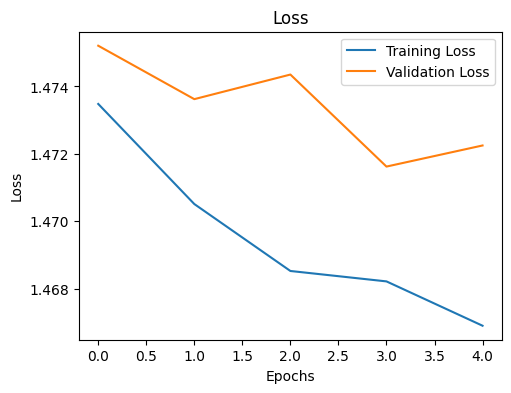

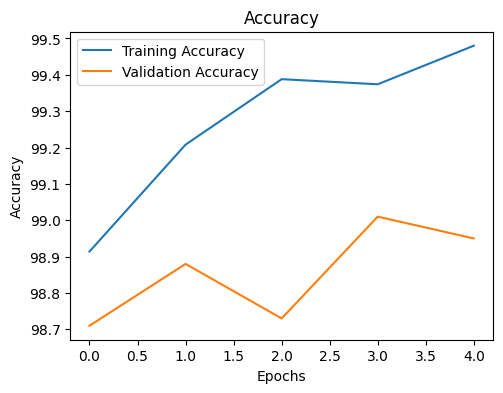

Test Accuracy: 99.14%


In [88]:
avg = 0
for i in range(len(validation_accuracy_history)):
  avg += validation_accuracy_history[i]
avg = avg / len(validation_accuracy_history)

print("Average validation accuracy =", avg)
# Plot training and validation metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(validation_loss_history, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history, label='Training Accuracy')
plt.plot(validation_accuracy_history, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.show()

# Test the model on the test set
model2.eval()
correct_test = 0
total_test = 0
test_loss = 0.0
with torch.no_grad():
    for images, one_hot_labels in test_loader:
        labels = torch.argmax(one_hot_labels, dim=1)
        outputs = model2(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
test_accuracy = 100 * correct_test / total_test
print(f'Test Accuracy: {test_accuracy:.2f}%')






The average prediction accuracy increased, and test accuracy also increased a bit (by approx 1%).
The time taken after applying batch normalisation is more in this case.




Visualizing the Convolution kernel trained from the network

We plot the 32 filters of convolution layer 1 and the higher layers in greyscale.

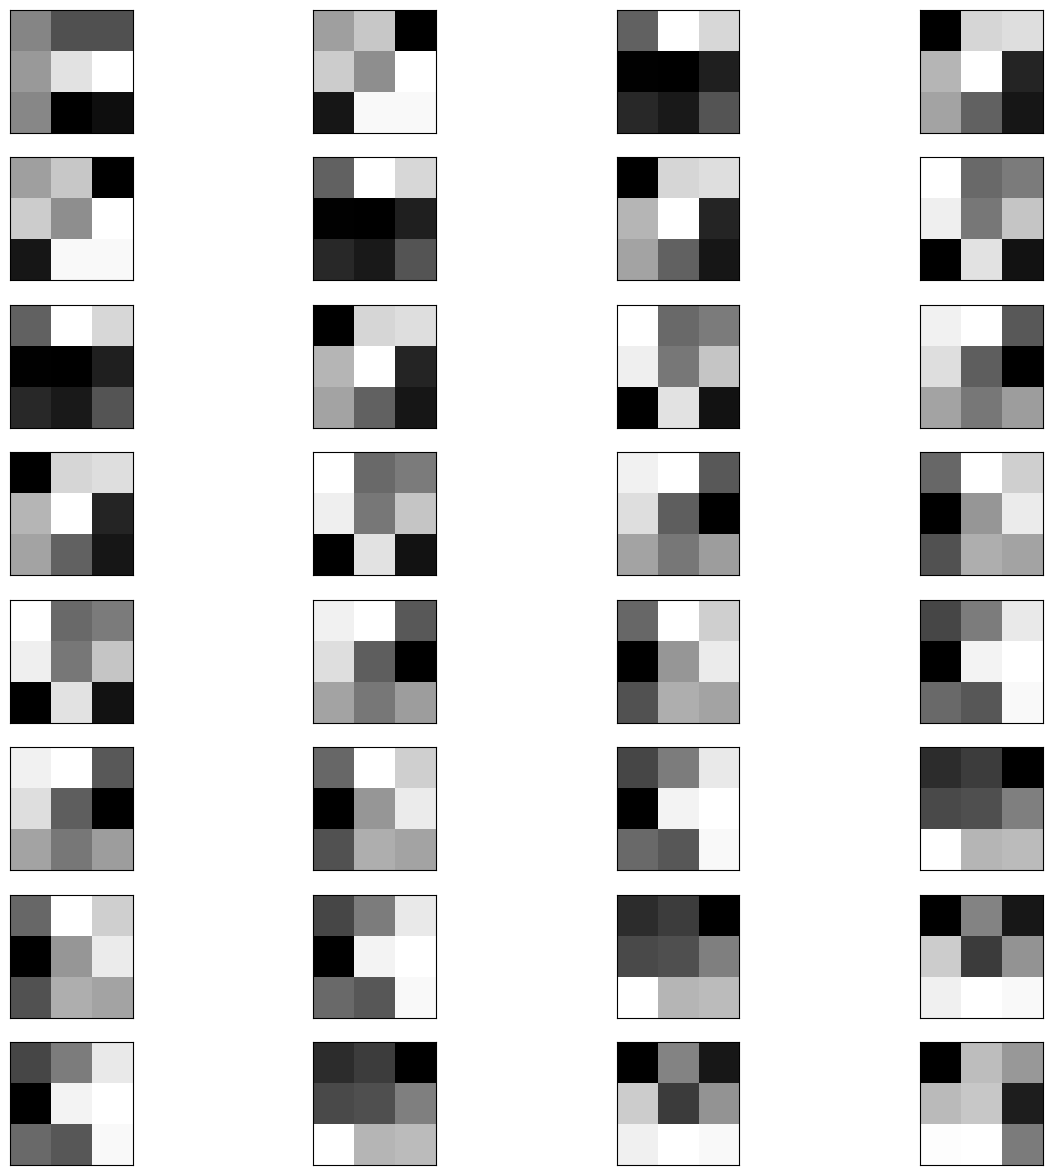

In [89]:
fig , axs = plt.subplots(8,4,figsize=(15, 15))
k=0
for i in range(8):
    for j in range(4):
        axs[k,j].xaxis.set_visible(False)
        axs[k,j].yaxis.set_visible(False)
        axs[k,j].imshow(model.conv1.weight[i].cpu().detach().numpy().reshape(3,3),  cmap="gray")
        i+=1
    k+=1

torch.Size([32, 3, 3])


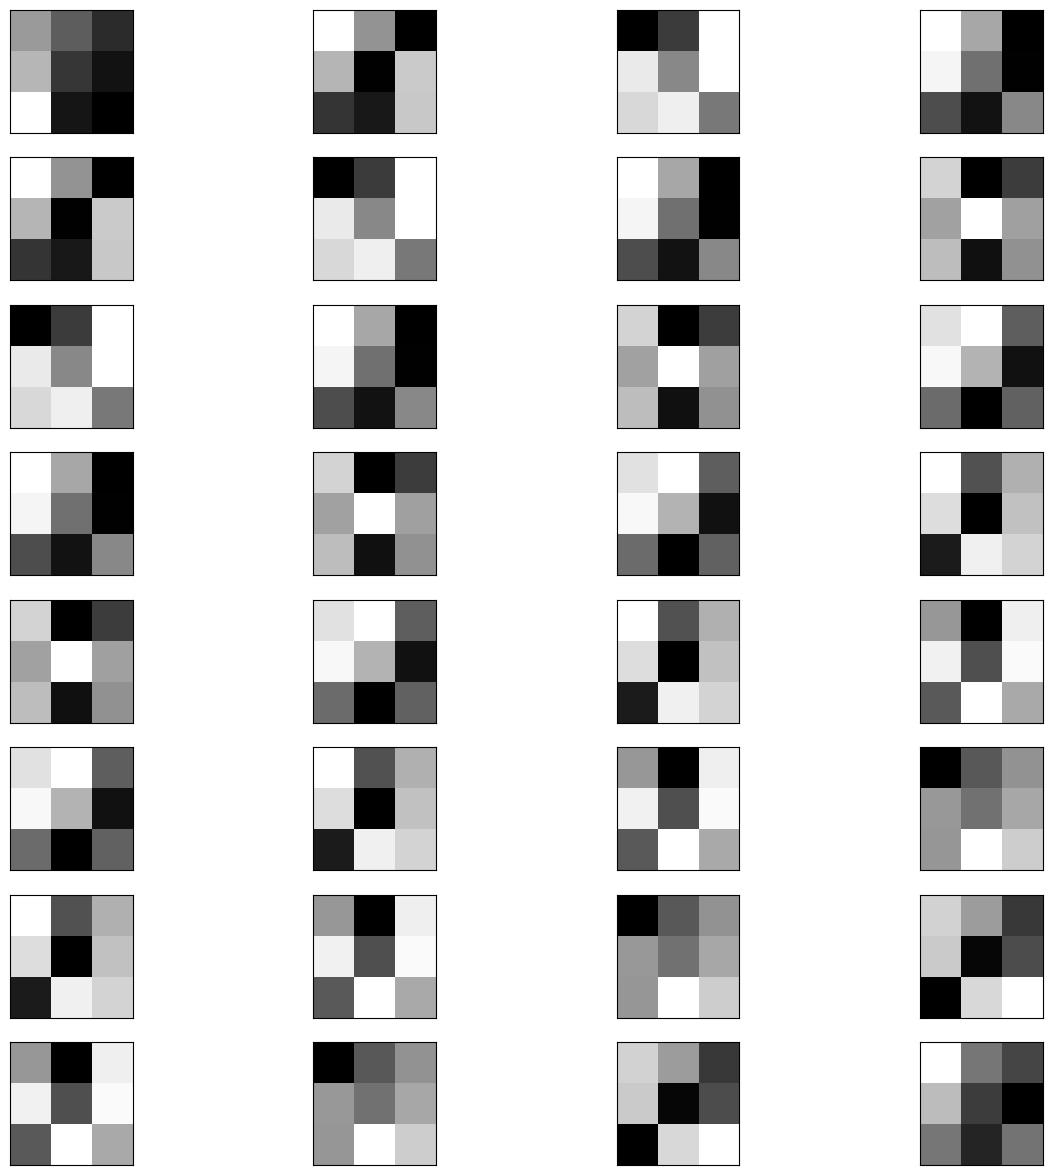

In [90]:
fig , axs = plt.subplots(8,4,figsize=(15, 15))
print(model.conv2.weight[0].shape)
k=0
for i in range(8):
    for j in range(4):
        axs[k,j].xaxis.set_visible(False)
        axs[k,j].yaxis.set_visible(False)
        axs[k,j].imshow(model.conv2.weight[0][i].cpu().detach().numpy().reshape(3,3),  cmap="gray")
        i+=1
    k+=1

**Occluding part of image**


Patch size = 5x5

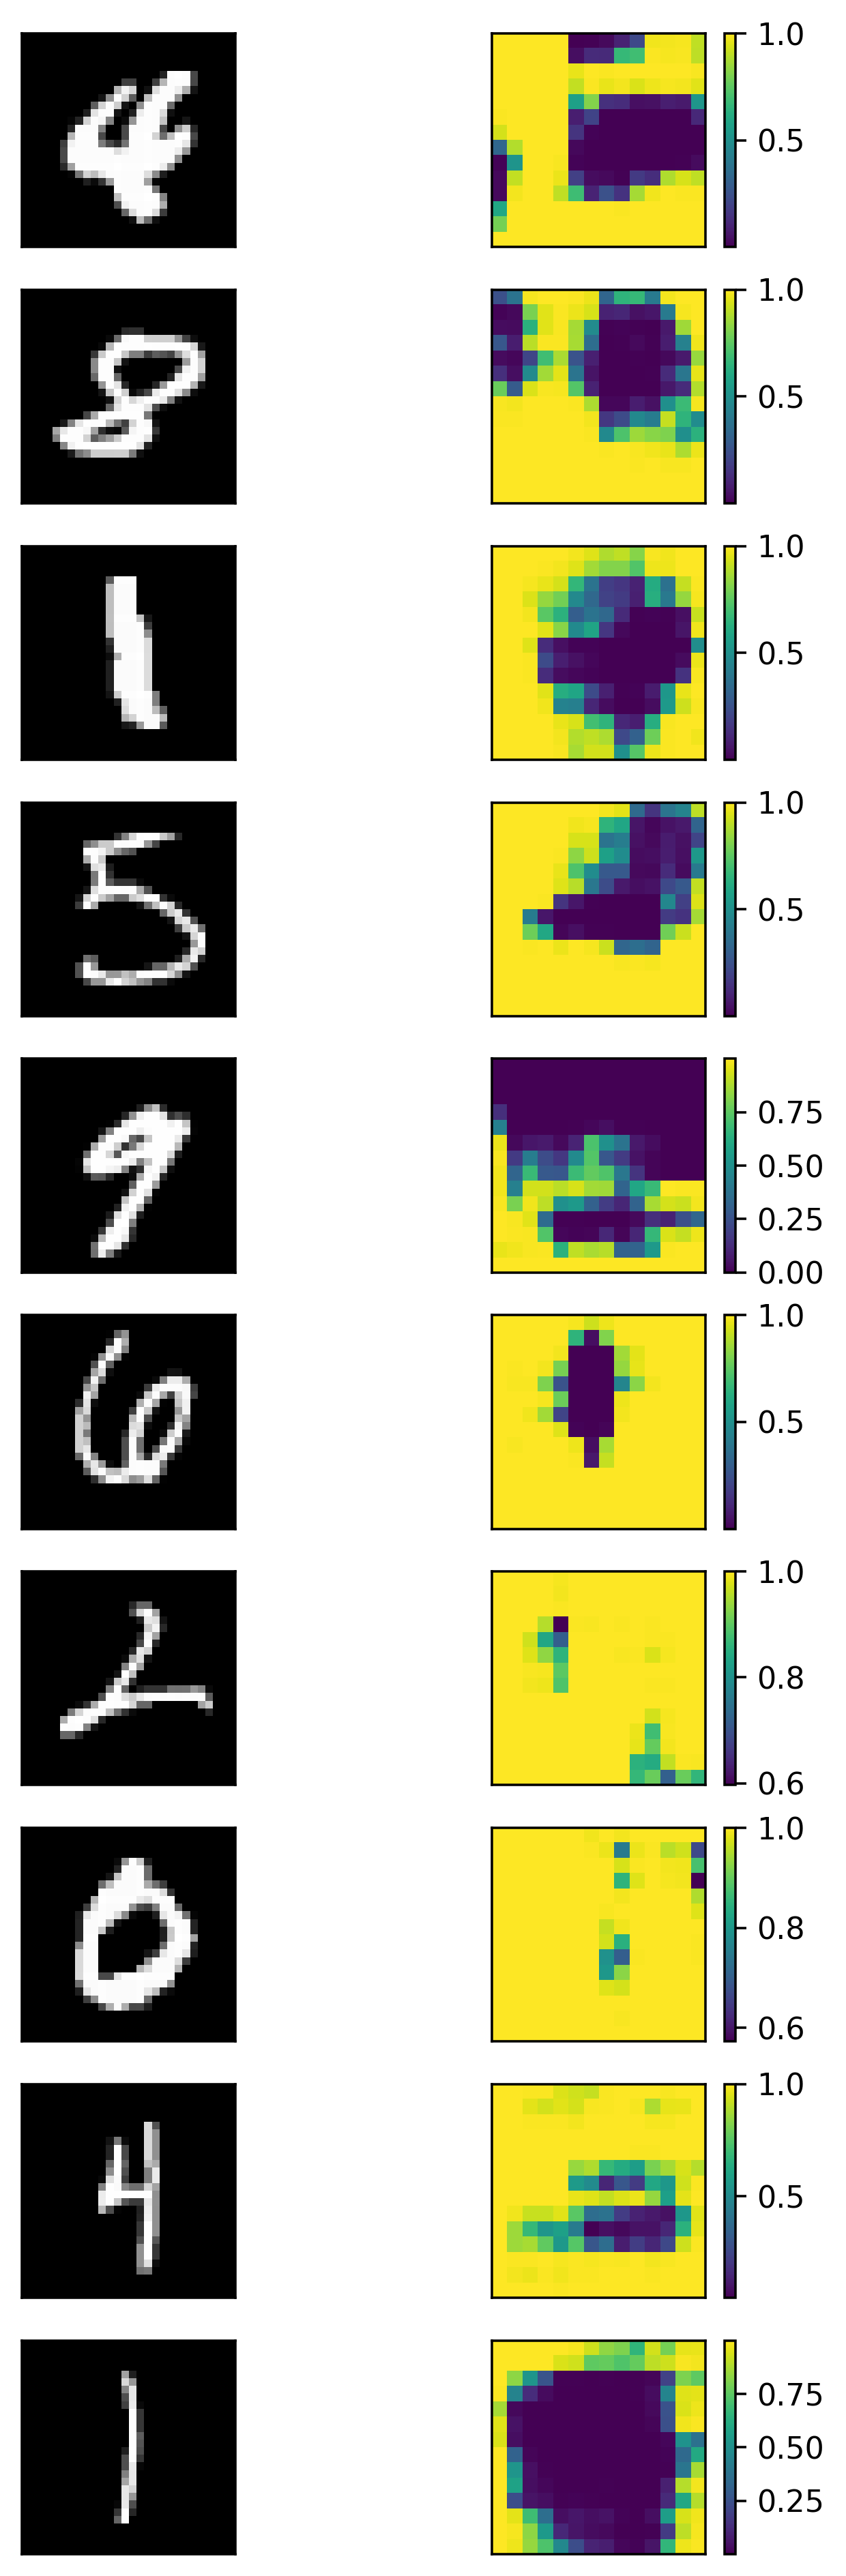

In [91]:
test_features, test_labels = next(iter(test_loader))
rand_samples = np.random.choice(test_features.shape[0],10)
siz = 14
prob = np.zeros((len(range(0,28-siz)),len(range(0,28-siz)),10))

for i in range(0,28-siz):
    for j in range(0,28-siz):
        for k in range(10):
            temp = torch.clone(test_features[rand_samples[k]].reshape(28,28))
            temp[i:i+siz,j:j+siz] = torch.from_numpy(np.full((siz,siz),1))
            prob[i,j,k]=model.forward(temp.reshape(1,1,28,28))[0][test_labels[rand_samples[k]].argmax().item()].item()
fig , axs = plt.subplots(10,2,figsize=(5, 15),dpi=320)
k=0
for i in range(10):

    axs[i,0].xaxis.set_visible(False)
    axs[i,0].yaxis.set_visible(False)
    axs[i,0].imshow(test_features[rand_samples[i]].reshape(28,28),  cmap="gray")
    axs[i,1].xaxis.set_visible(False)
    axs[i,1].yaxis.set_visible(False)
    im = axs[i,1].imshow(prob[:,:,i])
    plt.colorbar(im, ax = axs[i,1])
k+=1

In [92]:
X = torch.from_numpy(np.random.normal(loc = 128, scale = 10,size=(28, 28))).reshape(1,1,28,28).float()
base_pred = model2.forward(X)

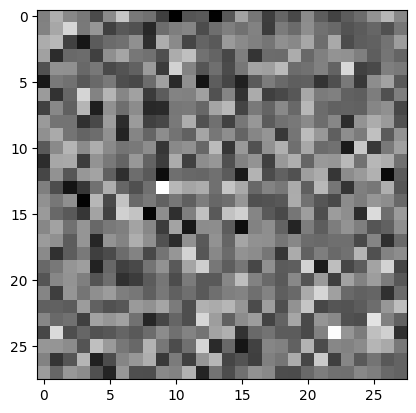

In [93]:
plt.imshow(X.detach().numpy().reshape(28,28),cmap='gray')

**Adversarial Examples**


**Non targetted attack**

In [94]:
from torch.autograd import Variable

numbers_to_make = [0,1,2,3,4,5,6,7,8,9]
def non_targetted_attack(n):

            noise = np.random.normal(loc=128, scale=10, size=(28,28))
            noise_tensor = torch.from_numpy(noise).reshape(1,1,28,28).float()
            # Calculate logits
            logit_values = []
            for step in range(5000):
                noise_tensor = Variable(noise_tensor, requires_grad=True)
                out = model2.conv1(noise_tensor)
                out = model2.maxpool1(torch.relu(out))
                out = model2.conv2(out)
                out = model2.maxpool2(torch.relu(out))
                out = out.reshape(out.size(0), -1)
                out = model2.fc1(out)
                out = model2.fc2(out)
                loss = out[:, n]
                to_print = loss.cpu().detach().numpy()
                logit_values.append(to_print)
                loss.backward(retain_graph=True)
                input_grad = torch.sign(noise_tensor.grad.data)
                noise_tensor = noise_tensor+0.01*input_grad

            plt.plot(np.asfarray(logit_values))
            plt.title(f"Cost function for {n}")
            plt.show()

            print(f"Number to generate : {n}\tStep : {step}\tLogit value : {to_print}")
            to_plot = noise_tensor.cpu().reshape(28,28).detach().numpy()
            to_plot = to_plot - np.min(to_plot)
            to_plot = to_plot/np.max(to_plot)
            plt.imshow(to_plot)
            plt.colorbar()
            plt.title(f"Adversarial image generated for {n}")
            plt.show()

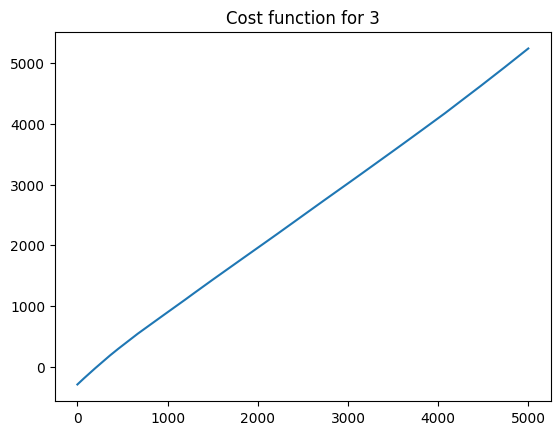

Number to generate : 3	Step : 4999	Logit value : [5242.0503]


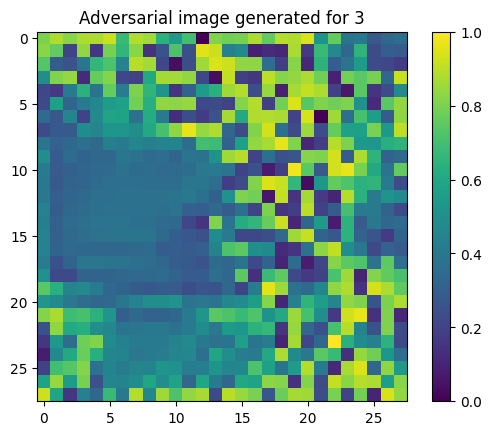

In [95]:
non_targetted_attack(3)

The cost function is seen to be increasing.

The prediction is better for numbers 0,1,3 .



In [98]:
import torch.nn.functional as F

numbers_to_make = [0,1,2,3,4,5,6,7,8,9]

def targetted_attack(n1, n2):
    noise = np.random.normal(loc=128, scale=10, size=(28, 28))
    noise_tensor = torch.from_numpy(noise).reshape(1, 1, 28, 28).float()

    # Check if there are any elements for class n2 in test_labels
    if (test_labels == n2).sum().item() > 0:
        indices = torch.where(test_labels == n2)[0][0]
        target_image = test_loader.dataset.data[indices, :, :].clone().reshape(1, 1, 28, 28).float()

        # Calculate logits
        logit_values = []
        for step in range(5000):
            noise_tensor = Variable(noise_tensor, requires_grad=True)
            out = model2.conv1(noise_tensor)
            out = model2.maxpool1(torch.relu(out))
            out = model2.conv2(out)
            out = model2.maxpool2(torch.relu(out))
            out = out.reshape(out.size(0), -1)
            out = model2.fc1(out)
            out = model2.fc2(out)
            Logit = out[:, n1]
            mse_error = F.mse_loss(noise_tensor, target_image)
            mse_error_to_print = (mse_error.cpu().detach().numpy())
            loss = Logit - 0.001 * mse_error

            to_print = loss.cpu().detach().numpy()
            logit_values.append(to_print)
            loss.backward(retain_graph=True)
            input_grad = torch.sign(noise_tensor.grad.data)
            noise_tensor = noise_tensor + 0.01 * input_grad

        plt.plot(np.asfarray(logit_values))
        plt.title(f"Cost function for {n1}")
        plt.show()

        print(f"Number to generate: {n1} and classified as {n2}")
        to_plot = noise_tensor.cpu().reshape(28, 28).detach().numpy()
        to_plot = to_plot - np.min(to_plot)
        to_plot = to_plot / np.max(to_plot)
        plt.imshow(to_plot)
        plt.colorbar()
        plt.title(f"Adversarial image generated for {n1}")
        plt.show()
    else:
        print(f"No examples found for class {n2} in test_labels.")

# Example usage:
# targetted_attack(0, 1)


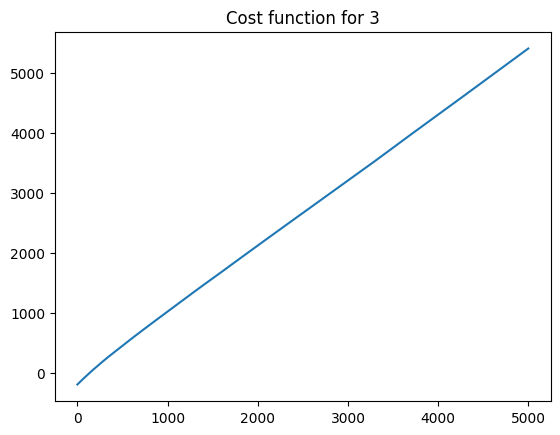

Number to generate: 3 and classified as 1


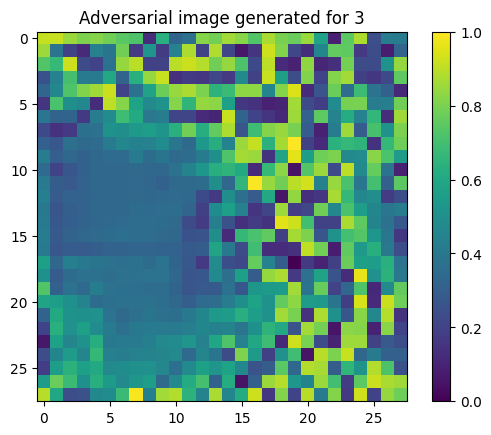

In [100]:
targetted_attack(3,1)

This is much better when compared to the previous plot.

The cost function is increasing in this case too.